## Modeling: Vanilla Linear Regression and LASSO(CV) Regression

In [1]:
#load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_pickle("project2_data/prop_df_cleaned")

### Create a subset of the data EXCLUDE: Address, Location(-179), Dollar/Sq.Ft., On Redfin, Lot Size (-367)

In [3]:
subset = ["Price", "Beds", "Baths", "Sq.Ft.", "HOA", "Year Built", "Zip Code", "prop_type"]
df2 = df[subset]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806 entries, 0 to 1138
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       806 non-null    float64
 1   Beds        806 non-null    Int64  
 2   Baths       806 non-null    float64
 3   Sq.Ft.      806 non-null    float64
 4   HOA         806 non-null    int64  
 5   Year Built  806 non-null    Int64  
 6   Zip Code    806 non-null    object 
 7   prop_type   806 non-null    object 
dtypes: Int64(2), float64(3), int64(1), object(2)
memory usage: 58.2+ KB


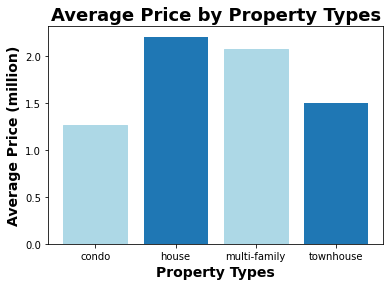

In [5]:
#property price by property type bar plot
plt.figure(figsize = [6, 4])
barlist = plt.bar(type_plot["prop_type"], type_plot["Price"])
for bar in range(0, len(barlist), 2):
    barlist[bar].set_color("lightblue")
plt.title("Average Price by Property Types", fontsize = 18, weight = "bold")
plt.ylabel("Average Price (million)", fontsize = 14, weight = "bold")
ytick_lab = ["0.0", "0.5", "1.0", "1.5", "2.0", ]
plt.yticks(ticks = list(range(0, 2500000, 500000)), labels = ytick_lab)
plt.xlabel("Property Types", fontsize = 14, weight = "bold")
xtick_lab = ["condo", "house", "multi-family", "townhouse"]
plt.xticks(ticks = list(range(4)), labels = xtick_lab)
plt.savefig("avg_property_price_by_type.svg", orientation = "landscape");

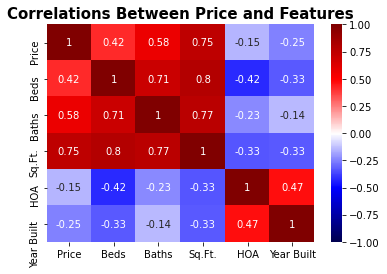

In [6]:
#look at correlations between continous variables
sns.heatmap(df2.corr(), cmap = "seismic", annot = True, vmin = -1, vmax = 1)
plt.title("Correlations Between Price and Features", fontsize = 15, weight = "bold")
plt.savefig("proj2_heatmap.svg");

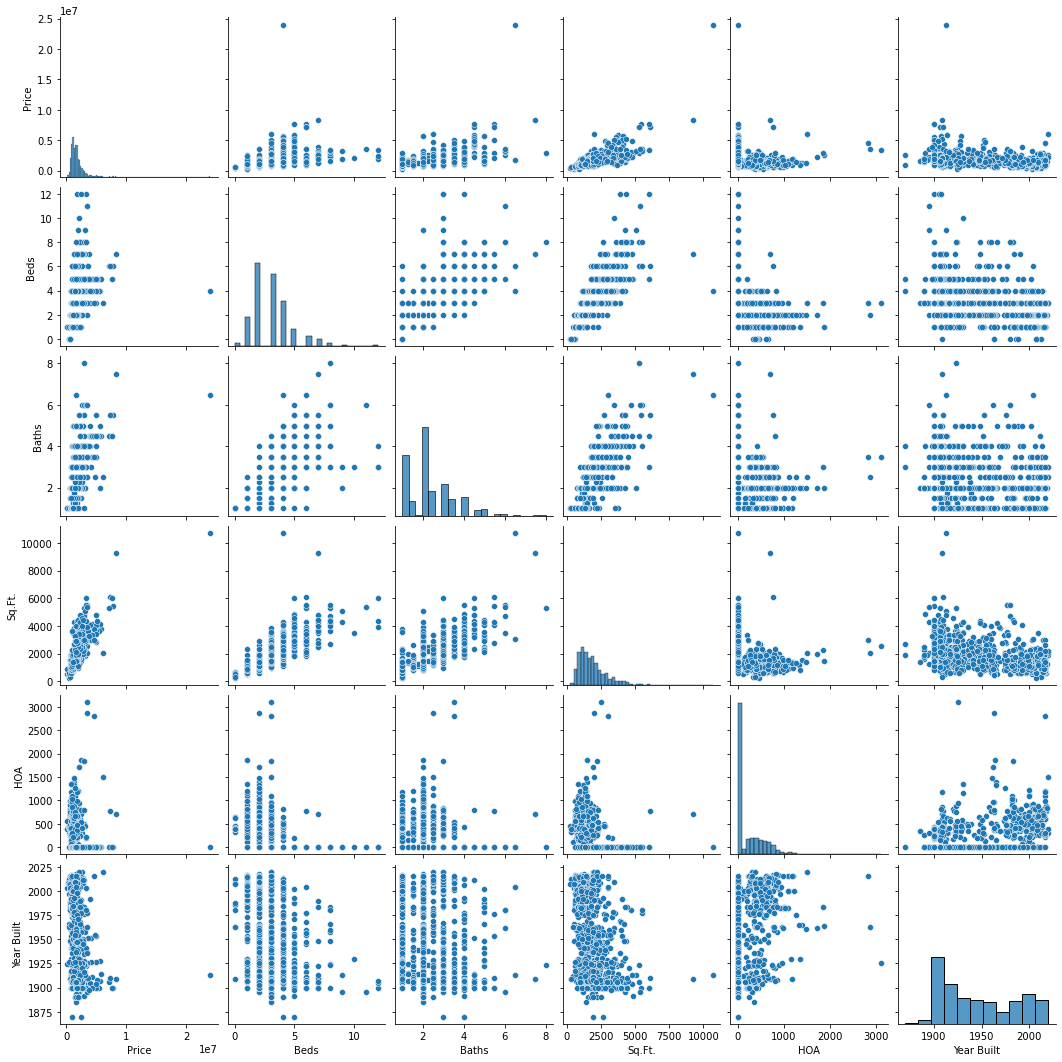

In [7]:
sns.pairplot(df2)

In [8]:
df2.describe()

,Price,Beds,Baths,Sq.Ft.,HOA,Year Built
count,8.060000e+02,806.000000,806.000000,806.000000,806.000000,806.000000
mean,1.774622e+06,3.083127,2.316377,1903.315136,245.625310,1946.485112
std,1.254484e+06,1.679778,1.133728,1079.996170,365.145802,39.301183
min,1.876200e+05,0.000000,1.000000,254.000000,0.000000,1870.000000
25%,1.100000e+06,2.000000,1.500000,1135.000000,0.000000,1910.000000
50%,1.550000e+06,3.000000,2.000000,1642.000000,0.000000,1937.000000
75%,2.100000e+06,4.000000,3.000000,2345.000000,436.750000,1983.000000
max,2.400000e+07,12.000000,8.000000,10725.000000,3099.000000,2020.000000


In [9]:
#import required functions for model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [10]:
#split dataframe into features and target
X = df2[["Beds", "Baths", "Sq.Ft.", "HOA", "Year Built"]]
y = df2["Price"]
X.head()

,Beds,Baths,Sq.Ft.,HOA,Year Built
0,4,2.0,1428.0,0,1951
3,3,2.0,1550.0,0,1900
4,4,4.0,3315.0,0,1973
6,3,3.0,1934.0,0,1957
7,6,4.0,2872.0,0,1945


In [11]:
#define function to split the data and fit a linear model
def split_and_validate(X, y):
    """For a set of features and target X, y, perform a 80/20 train/val split, 
       fit and validate a linear regression model, and report results
       
       Parameters:
           X: a dataframe containing features of interest
           y: a pandas series containing the target
        
       Returns: linear model results
    """
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size = 0.2, random_state = 11)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.3f}') 

In [12]:
#fit a linear model with all five continuous predictors
split_and_validate(X, y)


Validation R^2 score was: 0.6027166244114702
Feature coefficient results: 

Beds : -219463.463
Baths : 221919.568
Sq.Ft. : 841.709
HOA : 291.146
Year Built : -3816.469


In [13]:
#log transform Size and Price, R^2 increases significantly (tried log_baths, log_beds, meh...)
X1 = X.copy()
X1["log_size"] = np.log(X1["Sq.Ft."])
X1 = X1.drop(["Sq.Ft."], axis = 1)
y1 = np.log(y)
split_and_validate(X1, y1)


Validation R^2 score was: 0.7381358034966143
Feature coefficient results: 

Beds : -0.070
Baths : 0.083
HOA : 0.000
Year Built : -0.002
log_size : 0.802


In [14]:
#convert year built to age of house
X2 = X1.copy()
X2["prop_age"] = 2021 - X2["Year Built"]
X2 = X2.drop(["Year Built"], axis = 1)
y1 = np.log(y)
split_and_validate(X2, y1)


Validation R^2 score was: 0.7381358034966139
Feature coefficient results: 

Beds : -0.070
Baths : 0.083
HOA : 0.000
log_size : 0.802
prop_age : 0.002


In [15]:
#add prop_type as a dummy variable to the features
cat_prop_type = df2.loc[:, ["prop_type"]]

ohe = OneHotEncoder(drop = "first", sparse = False)
ohe.fit(cat_prop_type)
ohe_prop_type = ohe.transform(cat_prop_type)
columns = ohe.get_feature_names(["prop_type"])
prop_type_df = pd.DataFrame(ohe_prop_type, columns = columns, index = cat_prop_type.index)
print(prop_type_df.shape)
prop_type_df.head()

(806, 3)


,prop_type_house,prop_type_multi_fam,prop_type_townhouse
0,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0


In [16]:
X3 = X2.copy()
X3 = pd.concat([prop_type_df, X3], axis = 1)
print(X3.columns)
y1 = np.log(y)
split_and_validate(X3, y1) #R^2 increases from 0.738 to 0.772

Index(['prop_type_house', 'prop_type_multi_fam', 'prop_type_townhouse', 'Beds',
       'Baths', 'HOA', 'log_size', 'prop_age'],
      dtype='object')

Validation R^2 score was: 0.7723019443321877
Feature coefficient results: 

prop_type_house : 0.114
prop_type_multi_fam : -0.174
prop_type_townhouse : 0.001
Beds : -0.033
Baths : 0.054
HOA : 0.000
log_size : 0.829
prop_age : 0.001


In [17]:
zip_counts = df2["Zip Code"].value_counts()

#map the few least-represented zip to an "other" category
zip_other = list(zip_counts[zip_counts < 8].index)

df3 = df2.copy()
df3["Zip Code"] = df2["Zip Code"].replace(zip_other, 'other')

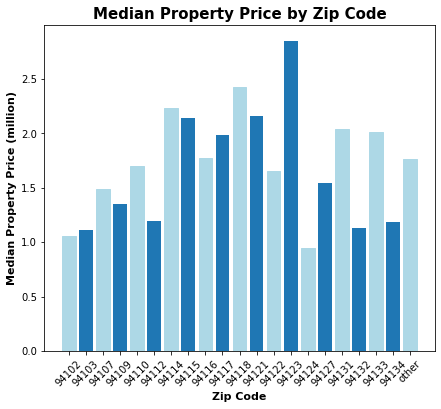

In [33]:
#bar plot for median property price by zip code in SF
zip_plot = df3.groupby(["Zip Code"])["Price"].mean().reset_index()
plt.figure(figsize = [7, 6])

barlist = plt.bar(zip_plot["Zip Code"], zip_plot["Price"])
for bar in range(0, len(barlist), 2):
    barlist[bar].set_color("lightblue")
    
plt.title("Median Property Price by Zip Code", fontsize = 15, weight = "bold")
plt.ylabel("Median Property Price (million)", fontsize = 11, weight = "bold")
ytick_lab = ["0.0", "0.5", "1.0", "1.5", "2.0", "2.5"]
plt.yticks(ticks = list(range(0, 3000000, 500000)), labels = ytick_lab)
plt.xlabel("Zip Code", fontsize = 11, weight = "bold")
plt.xticks(rotation = 45)
plt.savefig("bar_median_prop_price_by_zip.svg", orientation = "landscape");

In [20]:
zip_plot

,Zip Code,Price
0,94102,1.056914e+06
1,94103,1.113900e+06
2,94107,1.488708e+06
3,94109,1.351008e+06
4,94110,1.703690e+06
5,94112,1.198404e+06
6,94114,2.233754e+06
7,94115,2.139537e+06
8,94116,1.778200e+06
9,94117,1.984998e+06


In [21]:
#add zip code as a dummy variable to the features
cat_zip = df3.loc[:, ["Zip Code"]]

ohe = OneHotEncoder(drop = "first", sparse = False)
ohe.fit(cat_zip)
ohe_zip = ohe.transform(cat_zip)
columns = ohe.get_feature_names(["Zip Code"])
zip_df = pd.DataFrame(ohe_zip, columns = columns, index = cat_zip.index)
print(zip_df.shape)
zip_df.columns

(806, 20)


Index(['Zip Code_94103', 'Zip Code_94107', 'Zip Code_94109', 'Zip Code_94110',
       'Zip Code_94112', 'Zip Code_94114', 'Zip Code_94115', 'Zip Code_94116',
       'Zip Code_94117', 'Zip Code_94118', 'Zip Code_94121', 'Zip Code_94122',
       'Zip Code_94123', 'Zip Code_94124', 'Zip Code_94127', 'Zip Code_94131',
       'Zip Code_94132', 'Zip Code_94133', 'Zip Code_94134', 'Zip Code_other'],
      dtype='object')

In [22]:
X4 = X3.copy()
X4 = pd.concat([zip_df, X4], axis = 1)
y1 = np.log(y)
split_and_validate(X4, y1) #R^2 increases from 0.772 to 0.838


Validation R^2 score was: 0.8383820940611334
Feature coefficient results: 

Zip Code_94103 : -0.022
Zip Code_94107 : 0.070
Zip Code_94109 : 0.060
Zip Code_94110 : 0.055
Zip Code_94112 : -0.267
Zip Code_94114 : 0.152
Zip Code_94115 : 0.191
Zip Code_94116 : -0.111
Zip Code_94117 : 0.176
Zip Code_94118 : 0.145
Zip Code_94121 : -0.018
Zip Code_94122 : -0.026
Zip Code_94123 : 0.297
Zip Code_94124 : -0.425
Zip Code_94127 : -0.095
Zip Code_94131 : 0.036
Zip Code_94132 : -0.265
Zip Code_94133 : 0.178
Zip Code_94134 : -0.281
Zip Code_other : 0.196
prop_type_house : 0.278
prop_type_multi_fam : -0.048
prop_type_townhouse : 0.081
Beds : -0.021
Baths : 0.049
HOA : 0.000
log_size : 0.704
prop_age : 0.000


### EXPLORE interactions b/t continuous predictors (too many if include cat predictors)

In [23]:
X5 = X2.copy()

from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures(degree = 2,interaction_only = True)
X5_poly = p.fit_transform(X5)

y1 = np.log(y)

X_train, X_val, y_train, y_val = train_test_split(X5_poly, y1, test_size = 0.2, random_state = 11)
    
# fit linear regression to training data
lr = LinearRegression()
lr.fit(X_train, y_train)

# score fit model on validation data
val_score = lr.score(X_val, y_val)

# report results
print('\nValidation R^2 score was:', val_score)
print('Feature coefficient results: \n')
for feature, coef in zip(p.get_feature_names(X5.columns), lr.coef_):
    print(feature, ':', f'{coef:.3f}') 


Validation R^2 score was: 0.7255150387200238
Feature coefficient results: 

1 : 0.000
Beds : 0.190
Baths : -0.480
HOA : -0.002
log_size : 0.444
prop_age : -0.012
Beds Baths : -0.015
Beds HOA : 0.000
Beds log_size : -0.013
Beds prop_age : -0.001
Baths HOA : -0.000
Baths log_size : 0.065
Baths prop_age : 0.001
HOA log_size : 0.000
HOA prop_age : -0.000
log_size prop_age : 0.002


### ^Interaction terms don't seem to help

### Fitting a LASSO(CV) regression:

In [24]:
X_tv, X_test, y_tv, y_test = train_test_split(X4, y1, test_size = 0.2, random_state = 11)

In [25]:
print(X_tv.shape, X_test.shape, y_tv.shape, y_test.shape)

(644, 28) (162, 28) (644,) (162,)


In [26]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_tv.values)

X_tr = std.transform(X_tv.values)
X_te = std.transform(X_test.values)

In [27]:
lasso_model = LassoCV(cv=5)
lasso_model.fit(X_tr, y_tv)

LassoCV(cv=5)

In [28]:
#(standardized) coefficients when refitting data using that best alpha
lasso_result = pd.DataFrame(list(zip(X_tv.columns, lasso_model.coef_)))

# make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

# R^2 on the test set using this model
r2_score(y_test, test_set_pred)

0.8343531039263663

In [29]:
lasso_result.rename(columns = {0:"Features", 1:"Coef"}, inplace = True)
zipcode_effect = lasso_result.iloc[:20, :]
zipcode_effect.sort_values("Coef")

,Features,Coef
4,Zip Code_94112,-0.072662
13,Zip Code_94124,-0.071389
16,Zip Code_94132,-0.041216
18,Zip Code_94134,-0.037760
10,Zip Code_94121,-0.014193
11,Zip Code_94122,-0.013349
7,Zip Code_94116,-0.011472
0,Zip Code_94103,-0.009003
14,Zip Code_94127,-0.008342
2,Zip Code_94109,0.000000


In [30]:
other_factors = lasso_result.iloc[20:, :]
other_factors

,Features,Coef
20,prop_type_house,0.115890
21,prop_type_multi_fam,-0.029401
22,prop_type_townhouse,0.017993
23,Beds,-0.015010
24,Baths,0.044833
25,HOA,0.039435
26,log_size,0.363805
27,prop_age,0.015232


### Residuals vs predicted values

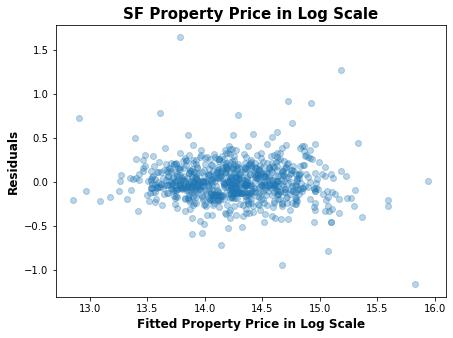

In [31]:
#residual plot with all of the records to examine model fit
residuals = lasso_model.predict(std.transform(X4)) - y1

plt.figure(figsize = [7, 5])
plt.scatter(lasso_model.predict(std.transform(X4)), residuals, alpha = 0.3)
plt.title("SF Property Price in Log Scale", fontsize = 15, weight = "bold")
plt.ylabel("Residuals", fontsize = 12, weight = "bold")
plt.xlabel("Fitted Property Price in Log Scale", fontsize = 12, weight = "bold");

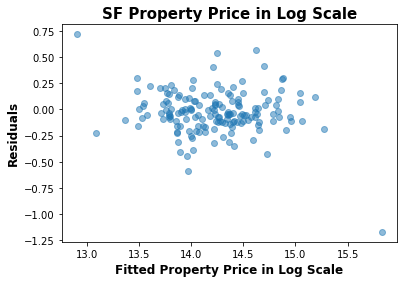

In [32]:
#residual plot for test set
residuals_test = lasso_model.predict(X_te) - y_test

plt.figure(figsize = [6, 4])
plt.scatter(lasso_model.predict(X_te), residuals_test, alpha = 0.5)
plt.title("SF Property Price in Log Scale", fontsize = 15, weight = "bold")
plt.ylabel("Residuals", fontsize = 12, weight = "bold")
plt.xlabel("Fitted Property Price in Log Scale", fontsize = 12, weight = "bold")
plt.savefig("residual_plot_LASSO.svg");